In [ ]:
!pip install qualtran --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 909.4/909.4 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.4/51.4 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.3/535.3 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.0/168.0 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.8/249.8 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.8/177.8 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 17.1 MB/s eta 0

In [ ]:
import numpy as np
import sympy
import matplotlib.pyplot as plt
import IPython
from functools import cached_property

from qualtran.bloqs.data_loading import QROM, SelectSwapQROM
from qualtran.drawing import show_call_graph, show_counts_sigma, show_bloq, show_bloqs, draw_musical_score, get_musical_score_data

In [ ]:
def show_t_counts(bloq: 'Bloq', title: str):
  # Helper method to display total T gate counts of bloq
  IPython.display.display(IPython.display.Markdown(title))
  IPython.display.display(IPython.display.Math(sympy.latex(bloq.t_complexity().t)))

## Overview of QROMs
The action of a QROM can be described as
$$
        \text{QROM}_{s_1, s_2, \dots, s_K}^{d_1, d_2, \dots, d_L}
        |s_1\rangle |s_2\rangle \dots |s_K\rangle
        |0\rangle^{\otimes b_1} |0\rangle^{\otimes b_2} \dots |0\rangle^{\otimes b_L}
        \rightarrow
        |s_1\rangle |s_2\rangle \dots |s_K\rangle
        |d_1[s_1, s_2, \dots, s_k]\rangle
        |d_2[s_1, s_2, \dots, s_k]\rangle \dots
        |d_L[s_1, s_2, \dots, s_k]\rangle
$$

A behavior of a QROM can be understood in terms of its classical analogue, where a for-loop
over one or more (selection) indices can be used to load one or more classical datasets, where
each of the classical dataset can be multidimensional.

```
>>> # N, M, P, Q, R, S, T are pre-initialized integer parameters.
>>> output = [np.zeros((P, Q)), np.zeros((R, S, T))]
>>> # Load two different classical datasets; each of different shape.
>>> data = [np.random.rand(N, M, P, Q), np.random.rand(N, M, R, S, T)]
>>> for i in range(N): # For loop over two selection indices i and j.
>>>     for j in range(M):
>>>        # Load two multidimensional classical datasets data[0] and data[1] s.t.
>>>        # |i, j⟩|0⟩  -> |i, j⟩|data[0][i, j, :]⟩|data[1][i, j, :]⟩
>>>        output[0] = data[0][i, j, :]
>>>        output[1] = data[1][i, j, :]
```

The parameters that control the behavior and costs of a QROM are -

1. Number of selection registers (eg: $i$, $j$) and their iteration lengths (eg: $N$, $M$).
2. Number of target registers, their quantum datatype and shape.
    - Number of target registers: One for each classical dataset to load (eg: $\text{data}[0]$
        and $\text{data}[1]$)
    - QDType of target registers: Depends on `dtype` of the $i$'th classical dataset
    - Shape of target registers: Depends on shape of classical data (eg: $(P, Q)$ and
        $(R, S, T)$ above)

### Specification of classical data via `data_or_shape`
Users can specify the classical data to load via QROM by passing in an appropriate value
for `data_or_shape` attribute. This is a list of numpy arrays or `Shaped` objects, where
each item of the list corresponds to a classical dataset to load.

Each classical dataset to load can be specified as a numpy array (or a `Shaped` object for
symbolic bloqs). The shape of the dataset is a union of the selection shape and target shape,
s.t.
$$
    \text{data[i].shape} = \text{selection_shape} + \text{target_shape[i]}
$$

Note that the $\text{selection_shape}$ should be same across all classical datasets to be
loaded and correspond to a tuple of iteration lengths of selection indices (i.e. $(N, M)$
in the example above).

The target shape of each classical dataset can be different and parameterizes the size of
the desired output that should be loaded in a target register.

### Number of selection registers and their iteration lengths
As describe in the previous section, the number of selection registers and their iteration
lengths can be inferred from the shape of the classical dataset. All classical datasets
to be loaded must have the same $\text{selection_shape}$, which is a tuple of iteration
lengths over each dimension of the dataset (i.e. the range for each nested for-loop).

In order to load a data set with $\text{selection_shape} == (P, Q, R, S)$ the QROM bloq
needs four selection registers with bitsizes $(p, q, r, s)$ where each of
$p,q,r,s \geq \log_2{P}, \log_2{Q}, \log_2{R}, \log_2{S}$.

In general, to load $K$ dimensional data, we use $K$ named selection registers
$(\text{selection}_0, \text{selection}_1, ..., \text{selection}_k)$ to index and
load the data. For the $i$'th selection register, its size is configured using
attribute $\text{selection_bitsizes[i]}$ and the iteration range is configued
using $\text{data_or_shape[0].shape[i]}$.

### Number of target registers, their quantum datatype and shape
QROM bloq uses one target register for each entry corresponding to classical dataset in the
tuple `data_or_shape`. Thus, to load $L$ classical datsets, we use $L$ names target registers
$(\text{target}_0, \text{target}_1, ..., \text{target}_L)$

Each named target register has a bitsize $b_{i}=\text{target_bitsizes[i]}$ that represents
the size of the register and depends upon the maximum value of individual elements in the
$i$'th classical dataset.

Each named target register has a shape that can be configured using attribute
$\text{target_shape[i]}$ that represents the number of target registers if the output to load
is multidimensional.

#### Parameters
 - `data_or_shape`: List of numpy ndarrays specifying the data to load. If the length of this list ($L$) is greater than one then we use the same selection indices to load each dataset. The shape of a classical dataset is a concatenation of selection_shape and target_shape[i]; i.e. `data_or_shape[i].shape = selection_shape + target_shape[i]`. Thus, each data set is required to have the same selection shape $(S_1, S_2, ..., S_K)$ and can have a different target shape given by `target_shapes[i]`. For symbolic QROMs, pass a list of `Shaped` objects instead with shape $(S_1, S_2, ..., S_K) + \text{target_shape}[i]$.
 - `selection_bitsizes`: The number of bits used to represent each selection register corresponding to the size of each dimension of the selection_shape $(S_1, S_2, ..., S_K)$. Should be the same length as the selection shape of each of the datasets and $2^\text{selection_bitsizes[i]} >= S_i$
 - `target_shapes`: Shape of target registers for each classical dataset to be loaded. Must be consistent with `data_or_shape` s.t. `len(data_or_shape) == len(target_shapes)` and `data_or_shape[-len(target_shapes[i]):] == target_shapes[i]`.
 - `target_bitsizes`: Bitsize (or qdtype) of the target registers for each classical dataset to be loaded. This can be deduced from the maximum element of each of the datasets. Must be consistent with `data_or_shape` s.t. `len(data_or_shape) == len(target_bitsizes)` and `target_bitsizes[i] >= max(data[i]).bitsize`.
 - `num_controls`: The number of controls to instanstiate a controlled version of this bloq.


# Analyze costs of loading 1D dataset using QROM and SelectSwapQROM

## Numerical and Symbolic cost analysis using QROM

In this section we will analyze the costs for loading 1D data using QROMs suggested in Babbush et. al. (2018)

###  References:    
  1. [Encoding Electronic Spectra in Quantum Circuits with Linear T Complexity](https://arxiv.org/abs/1805.03662).
      Babbush et. al. (2018). Figure 1.

#### Step-1: Visualize circuits for small number data elements

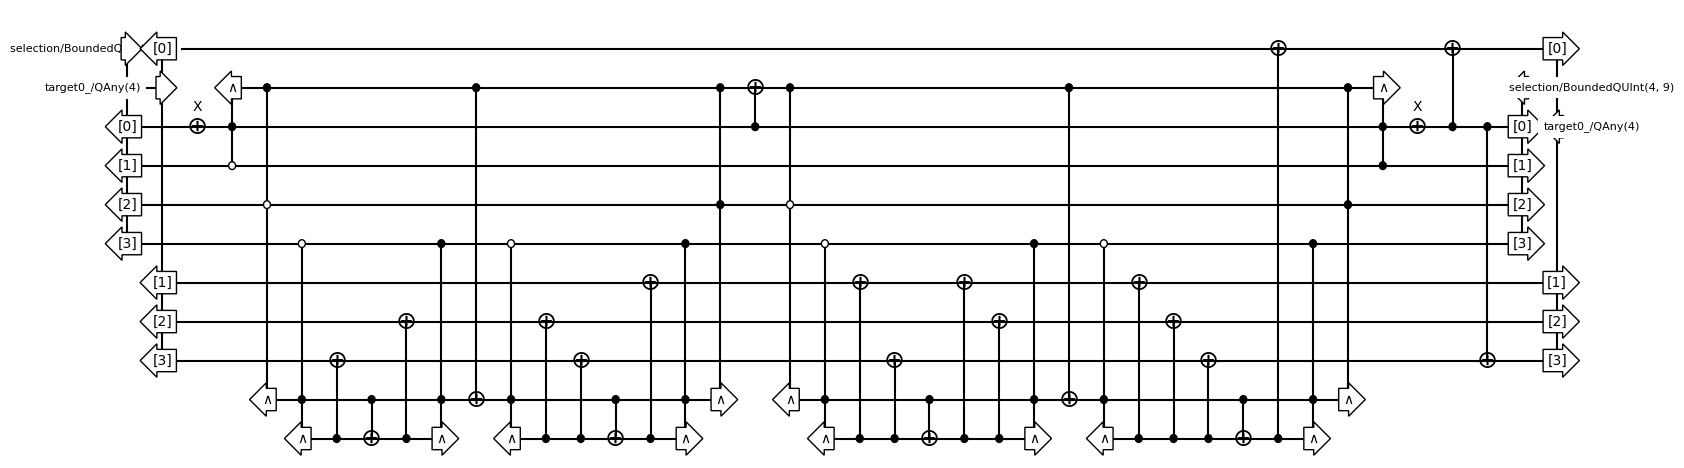

In [ ]:
data = [*range(1, 10)]
# Exercise: Construct a QROM bloq using `QROM.build_from_data`.
bloq = QROM.build_from_data(data)
# Exercise: Decompose the bloq and store the result in a new variable called `cbloq`.
cbloq = bloq.decompose_bloq()
# Plot a musical score diagram of the decomposed circuit.
fig, ax = draw_musical_score(get_musical_score_data(cbloq), unit_to_inches=0.5, max_width=12, max_height=20)
fig.set_size_inches(18, 5)

#### Step-2: Numerical cost analysis for large number of data elements

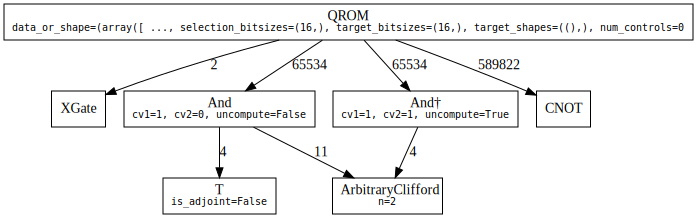

#### Counts totals:
 - `ArbitraryClifford(n=2)`: 983010
 - `CNOT`: 589822
 - `T`: 262136
 - `XGate`: 2

In [ ]:
data = [*range(2**16)]
# Exercise: Construct a QROM bloq using `QROM.build_from_data`.
bloq = QROM.build_from_data(data)
# Exercise: Construct a call graph and get bloq counts using `bloq.call_graph()`
g, sigma = bloq.call_graph()
# Exercise: Show the call graph using `show_call_graph(g)` and `show_counts_sigma(sigma)`
show_call_graph(g)
show_counts_sigma(sigma)

#### Step-3: Symbolic cost analysis

In [ ]:
N, b = sympy.symbols('N b')
# Exercise: Construct a QROM using `QROM.build_from_bitsize` and specify parameters $N$ and target_bitsize $b$.
bloq = QROM.build_from_bitsize(N, target_bitsizes=b)
# Show the T-counts of the constructed bloq using `show_t_counts(bloq)`.
show_t_counts(bloq, "### T-Counts for QROM to load a classical dataset of $N$ elements")

### T-Counts for QROM to load a classical dataset of $N$ elements

<IPython.core.display.Math object>

## Variable spaced QROM
When the input classical data contains consecutive entries of identical data elements to
load, the QROM also implements the "variable-spaced" QROM optimization described in Babbush et. al. (2020)

### References:    
  2. [Compilation of Fault-Tolerant Quantum Heuristics for Combinatorial Optimization](https://arxiv.org/abs/2007.07391).
      Babbush et. al. (2020). Figure 3.

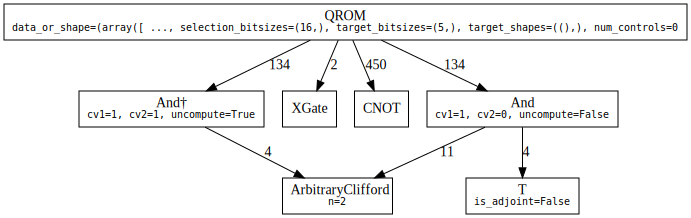

#### Counts totals:
 - `ArbitraryClifford(n=2)`: 2010
 - `CNOT`: 450
 - `T`: 536
 - `XGate`: 2

In [ ]:
# Large number of consecutive repeated elements in the data
data = [x.bit_length() for x in range(1, 2**16)]
# Exercise: Build the QROM bloq using `data` above and plot the call graph and show counts sigma as done above.
bloq = QROM.build_from_data(data)
g, sigma = bloq.call_graph()
show_call_graph(g)
show_counts_sigma(sigma)

## Numerical and Symbolic cost analysis using `SelectSwapQROM`
The `SelectSwapQROM` implements the optimized version of QROM described in Low et. al. (2018). It does not currently implement the measurement based uncomputation approach from Berry et. al. (2019) so the costs would be higher by a factor of 2x.

By default, if you do not specify a `log_block_size`, it will find the optimal block sizes the minimizes the T-counts for data.


### References:    
  3. [Trading T-gates for dirty qubits in state preparation and unitary synthesis](https://arxiv.org/abs/1812.00954).
  Low, Kliuchnikov, Schaeffer. 2018.

  4. [Qubitization of Arbitrary Basis Quantum Chemistry Leveraging Sparsity and Low Rank Factorization](https://arxiv.org/abs/1902.02134).
      Berry et. al. (2019). Appendix A. & B.

### Step-1: Numerical & Symbolic analysis for `SelectSwapQROM` using dirty ancilla qubits.

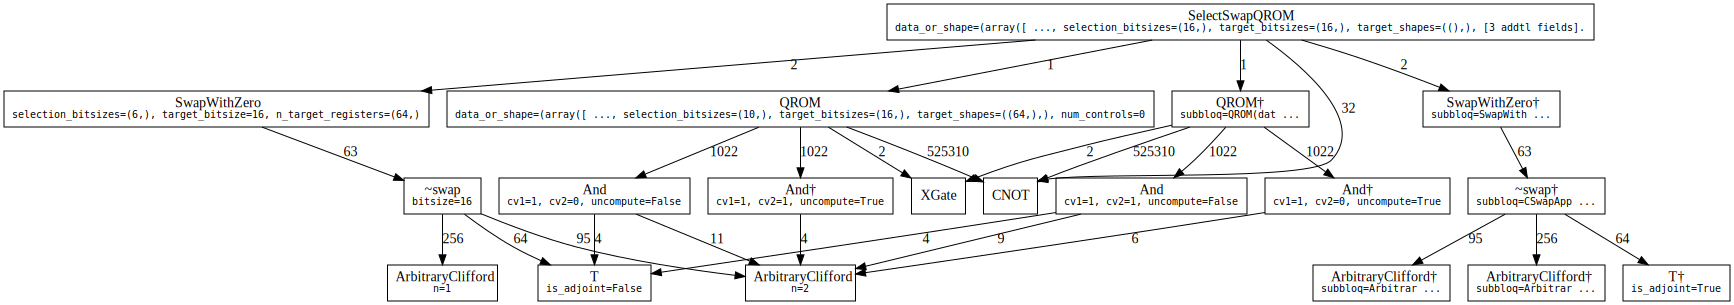

#### Counts totals:
 - `Adjoint(subbloq=ArbitraryClifford(n=1))`: 32256
 - `Adjoint(subbloq=ArbitraryClifford(n=2))`: 11970
 - `ArbitraryClifford(n=1)`: 32256
 - `ArbitraryClifford(n=2)`: 42630
 - `CNOT`: 1050652
 - `T`: 16240
 - `T†`: 8064
 - `XGate`: 4

In [ ]:
data = [*range(2**16)]
# Exercise: Build a SelectSwapQROM bloq using `data` via `SelectSwapQROM.build_from_data` and set `use_dirty_ancilla=True`.
bloq = SelectSwapQROM.build_from_data(data, use_dirty_ancilla=True)
# Exercise: Plot the call graph and show counts sigma as done above.
g, sigma = bloq.call_graph()
show_call_graph(g)
show_counts_sigma(sigma)

In [ ]:
N, b, k = sympy.symbols('N b k')
# Exercise: Construct a symbolic `SelectSwapQROM` using `SelectSwapQROM.build_from_bitsize` and specify parameters
# - data_len_or_shape: $N$
# - target_bitsizes: $b$
# - log_block_sizes: $k$
# - use_dirty_ancilla: True
bloq = SelectSwapQROM.build_from_bitsize(N, target_bitsizes=b, log_block_sizes=k, use_dirty_ancilla=True)
show_t_counts(bloq, "### T-Counts for SelectSwapQROM using Dirty Ancilla")

### T-Counts for SelectSwapQROM using Dirty Ancilla

<IPython.core.display.Math object>

### Step-2: Numerical & Symbolic analysis for `SelectSwapQROM` using clean ancilla qubits.

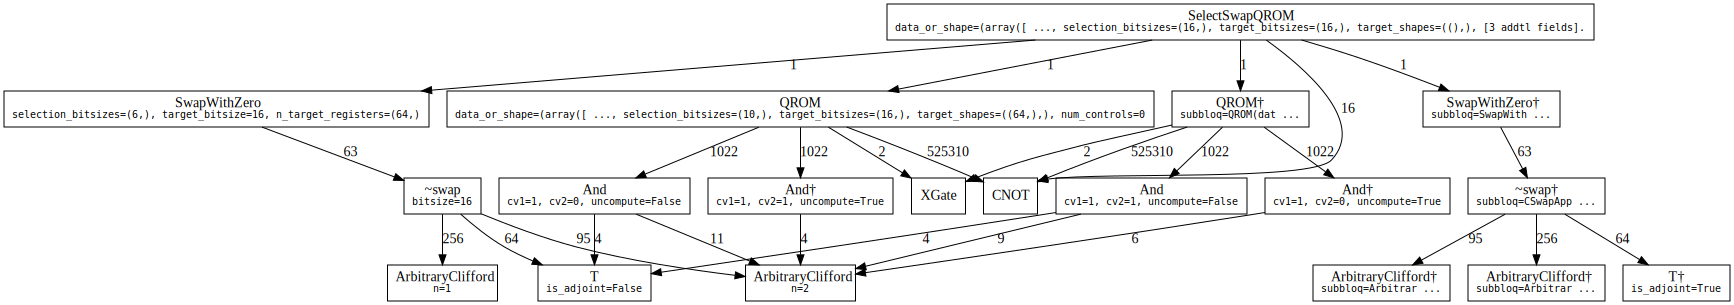

#### Counts totals:
 - `Adjoint(subbloq=ArbitraryClifford(n=1))`: 16128
 - `Adjoint(subbloq=ArbitraryClifford(n=2))`: 5985
 - `ArbitraryClifford(n=1)`: 16128
 - `ArbitraryClifford(n=2)`: 36645
 - `CNOT`: 1050636
 - `T`: 12208
 - `T†`: 4032
 - `XGate`: 4

In [ ]:
data = [*range(2**16)]
# Exercise: Build a SelectSwapQROM bloq using `data` via `SelectSwapQROM.build_from_data` and set `use_dirty_ancilla=False`.
bloq = SelectSwapQROM.build_from_data(data, use_dirty_ancilla=False)
# Exercise: Plot the call graph and show counts sigma as done above.
g, sigma = bloq.call_graph()
show_call_graph(g)
show_counts_sigma(sigma)

In [ ]:
N, b, k = sympy.symbols('N b k')
# Exercise: Construct a symbolic `SelectSwapQROM` using `SelectSwapQROM.build_from_bitsize` and specify parameters
# - data_len_or_shape: $N$
# - target_bitsizes: $b$
# - log_block_sizes: $k$
# - use_dirty_ancilla: False
bloq = SelectSwapQROM.build_from_bitsize(N, target_bitsizes=b, log_block_sizes=k, use_dirty_ancilla=False)
# Show the T-counts of the constructed bloq using `show_t_counts(bloq)`.
show_t_counts(bloq, "### T-Counts for SelectSwapQROM using Clean Ancilla")

### T-Counts for SelectSwapQROM using Clean Ancilla

<IPython.core.display.Math object>

### Compare 1D QROM and SelectSwapQROM (using clean & dirty ancilla)

In [ ]:
from qualtran.resource_counting import get_cost_value, QubitCount

data = [*range(2**10)]
log_block_sizes = [*range(1, 7)]

qroam_clean = SelectSwapQROM.build_from_data(data, use_dirty_ancilla=False)
qroam_dirty = SelectSwapQROM.build_from_data(data, use_dirty_ancilla=True)

costs_cache = {}
qroam_t_costs_clean, qroam_t_costs_dirty = [], []
qroam_qubit_costs_clean, qroam_qubit_costs_dirty = [], []
for b in log_block_sizes:
  print(f'{b=}')
  qroam_clean_curr = qroam_clean.with_log_block_sizes(log_block_sizes=[b])
  qroam_dirty_curr = qroam_dirty.with_log_block_sizes(log_block_sizes=[b])
  qroam_t_costs_clean.append(qroam_clean_curr.t_complexity().t)
  qroam_t_costs_dirty.append(qroam_dirty_curr.t_complexity().t)
  qroam_qubit_costs_clean.append(get_cost_value(qroam_clean_curr, QubitCount(), costs_cache=costs_cache))
  qroam_qubit_costs_dirty.append(get_cost_value(qroam_dirty_curr, QubitCount(), costs_cache=costs_cache))


qrom_t_cost = QROM.build_from_data(data).t_complexity().t
qrom_qubit_cost = get_cost_value(QROM.build_from_data(data),  QubitCount(), costs_cache=costs_cache)

b=1
b=2
b=3
b=4
b=5
b=6


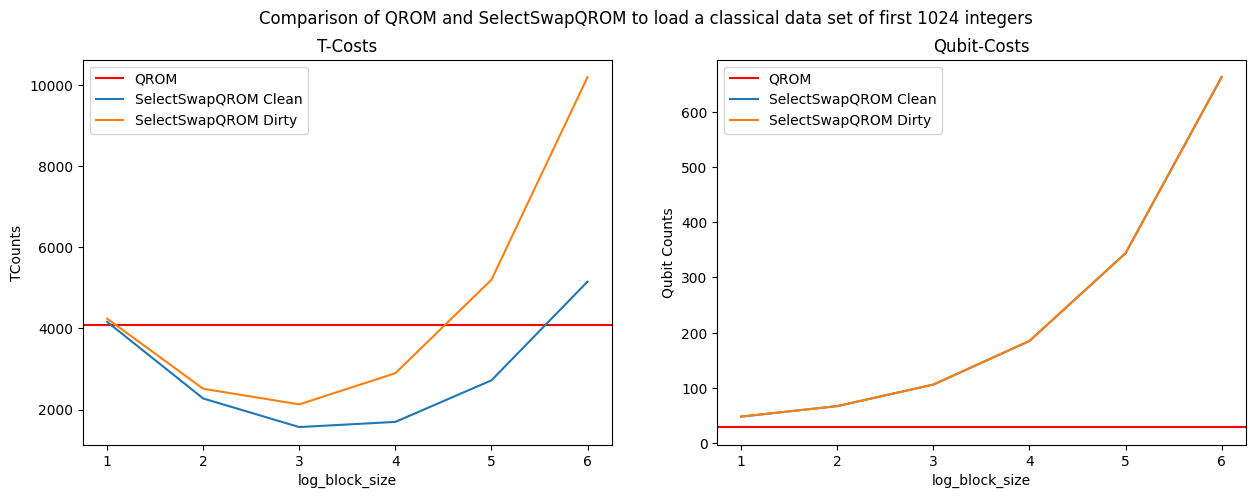

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Comparison of QROM and SelectSwapQROM to load a classical data set of first 1024 integers')
axs[0].axhline(y=qrom_t_cost, color='r', linestyle='-', label='QROM')
axs[0].plot(log_block_sizes, qroam_t_costs_clean, label='SelectSwapQROM Clean')
axs[0].plot(log_block_sizes, qroam_t_costs_dirty, label='SelectSwapQROM Dirty')
axs[0].set_title('T-Costs')
axs[0].set_xlabel('log_block_size')
axs[0].set_ylabel('TCounts')
axs[0].legend()


axs[1].axhline(y=qrom_qubit_cost, color='r', linestyle='-', label='QROM')
axs[1].plot(log_block_sizes, qroam_qubit_costs_clean, label='SelectSwapQROM Clean')
axs[1].plot(log_block_sizes, qroam_qubit_costs_dirty, label='SelectSwapQROM Dirty')
axs[1].set_title('Qubit-Costs')
axs[1].set_xlabel('log_block_size')
axs[1].set_ylabel('Qubit Counts')
axs[1].legend()

# Analyze costs of loading 2D datasets using QROM and SelectSwapQROM

Both `QROM` and `SelectSwapQROM` implementations support loading multi-dimesional classical datasets; i.e. data with multiple selection indices.

For QROM, this is straightforward (you recursively attach a unary iteration circuit for $i$'th index on the leaf nodes of unary iteration circuit for $i-1$'th index. This was used in the state preparation alias sampling introduces in the original Bubbush et. al. (2018) paper.


For SelectSwapQROM, the construction for how to load data with multiple selection registers without computing a contiguous register was given in Lee et. al. (2021), Appendix G. The `SelectSwapQROM` bloq implements this optimization and we will analyze the costs below.


###  References:    
  5. [Even more efficient quantum computations of chemistry
through tensor hypercontraction](https://arxiv.org/abs/2011.03494).
      Lee et. al. (2021). Appendix G.

###Step-1: QROM for 2D data

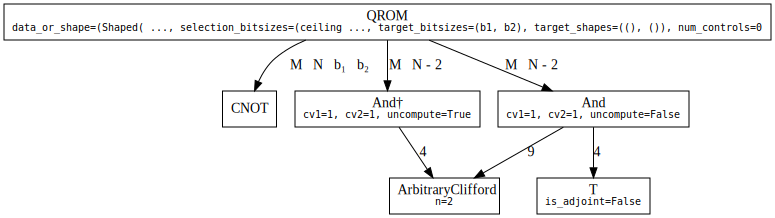

#### Counts totals:
 - `ArbitraryClifford(n=2)`: $\displaystyle 13 M N - 26$
 - `CNOT`: $\displaystyle M N b_{1} b_{2}$
 - `T`: $\displaystyle 4 M N - 8$

### T-Counts for QROM to load a classical dataset with shape $(N, M)$

<IPython.core.display.Math object>

In [ ]:
N, M, b1, b2 = sympy.symbols('N M, b1, b2')
# Exercise: Construct a symbolic `QROM` using `QROM.build_from_bitsize` and specify parameters
# - data_len_or_shape: $(N, M)$
# - target_bitsizes: $(b1, b2)$
bloq = QROM.build_from_bitsize((N, M), target_bitsizes=(b1, b2))
g, sigma = bloq.call_graph()
show_call_graph(g)
show_counts_sigma(sigma)
show_t_counts(bloq, "### T-Counts for QROM to load a classical dataset with shape $(N, M)$")

###Step-2: SelectSwapQROM using dirty ancilla qubits for 2D data

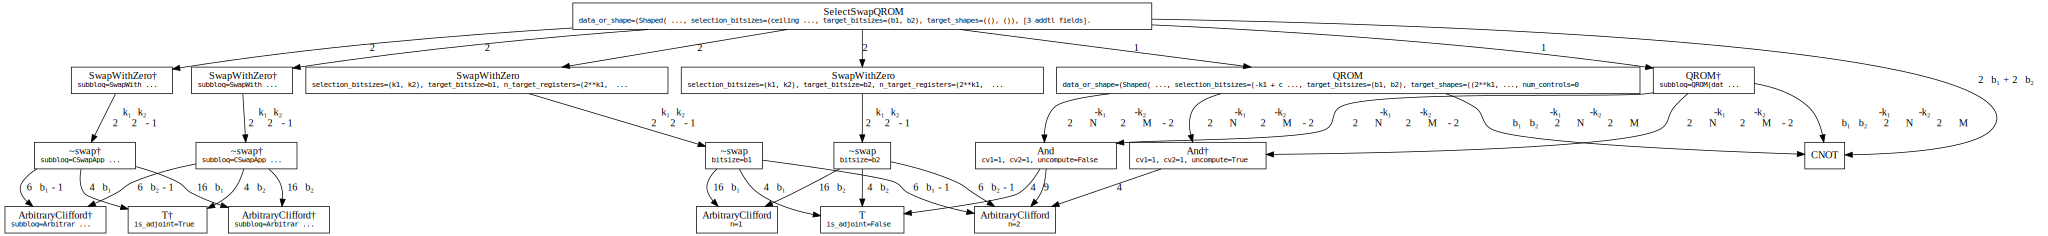

#### Counts totals:
 - `Adjoint(subbloq=ArbitraryClifford(n=1))`: $\displaystyle 32 b_{1} \cdot \left(2^{k_{1}} \cdot 2^{k_{2}} - 1\right) + 32 b_{2} \cdot \left(2^{k_{1}} \cdot 2^{k_{2}} - 1\right)$
 - `Adjoint(subbloq=ArbitraryClifford(n=2))`: $\displaystyle 2 \cdot \left(6 b_{1} - 1\right) \left(2^{k_{1}} \cdot 2^{k_{2}} - 1\right) + 2 \cdot \left(6 b_{2} - 1\right) \left(2^{k_{1}} \cdot 2^{k_{2}} - 1\right)$
 - `ArbitraryClifford(n=1)`: $\displaystyle 32 b_{1} \cdot \left(2^{k_{1}} \cdot 2^{k_{2}} - 1\right) + 32 b_{2} \cdot \left(2^{k_{1}} \cdot 2^{k_{2}} - 1\right)$
 - `ArbitraryClifford(n=2)`: $\displaystyle 2 \cdot \left(6 b_{1} - 1\right) \left(2^{k_{1}} \cdot 2^{k_{2}} - 1\right) + 2 \cdot \left(6 b_{2} - 1\right) \left(2^{k_{1}} \cdot 2^{k_{2}} - 1\right) + 26 \left\lceil{2^{- k_{1}} N}\right\rceil \left\lceil{2^{- k_{2}} M}\right\rceil - 52$
 - `CNOT`: $\displaystyle 2 b_{1} b_{2} \left\lceil{2^{- k_{1}} N}\right\rceil \left\lceil{2^{- k_{2}} M}\right\rceil + 2 b_{1} + 2 b_{2}$
 - `T`: $\displaystyle 8 b_{1} \cdot \left(2^{k_{1}} \cdot 2^{k_{2}} - 1\right) + 8 b_{2} \cdot \left(2^{k_{1}} \cdot 2^{k_{2}} - 1\right) + 8 \left\lceil{2^{- k_{1}} N}\right\rceil \left\lceil{2^{- k_{2}} M}\right\rceil - 16$
 - `T†`: $\displaystyle 8 b_{1} \cdot \left(2^{k_{1}} \cdot 2^{k_{2}} - 1\right) + 8 b_{2} \cdot \left(2^{k_{1}} \cdot 2^{k_{2}} - 1\right)$

### T-Counts for SelectSwapQROM(dirty ancilla) to load a dataset with shape=$(N, M)$, target_bitsizes=$(b_1, b_2)$, log_block_sizes = $(k_1, k_2)$ 

<IPython.core.display.Math object>

In [ ]:
N, M, b1, b2, k1, k2 = sympy.symbols('N M, b1, b2, k1, k2')
# Exercise: Construct a symbolic `SelectSwapQROM` using `SelectSwapQROM.build_from_bitsize` and specify parameters
# - data_len_or_shape: $(N, M)$
# - target_bitsizes: $(b1, b2)$
# - log_block_sizes: $(k1, k2)$
# - use_dirty_ancilla: True
bloq = SelectSwapQROM.build_from_bitsize((N, M), target_bitsizes=(b1, b2), log_block_sizes=(k1, k2), use_dirty_ancilla=True)
g, sigma = bloq.call_graph()
show_call_graph(g)
show_counts_sigma(sigma)
show_t_counts(bloq, "### T-Counts for SelectSwapQROM(dirty ancilla) to load a dataset with shape=$(N, M)$, target_bitsizes=$(b_1, b_2)$, log_block_sizes = $(k_1, k_2)$ ")

###Step-3: SelectSwapQROM using clean ancilla qubits for 2D data

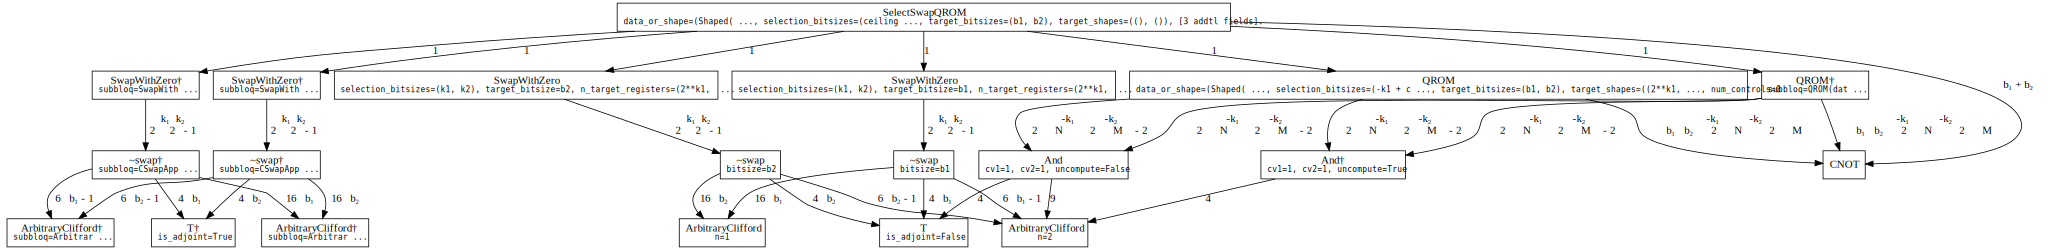

#### Counts totals:
 - `Adjoint(subbloq=ArbitraryClifford(n=1))`: $\displaystyle 16 b_{1} \cdot \left(2^{k_{1}} \cdot 2^{k_{2}} - 1\right) + 16 b_{2} \cdot \left(2^{k_{1}} \cdot 2^{k_{2}} - 1\right)$
 - `Adjoint(subbloq=ArbitraryClifford(n=2))`: $\displaystyle \left(6 b_{1} - 1\right) \left(2^{k_{1}} \cdot 2^{k_{2}} - 1\right) + \left(6 b_{2} - 1\right) \left(2^{k_{1}} \cdot 2^{k_{2}} - 1\right)$
 - `ArbitraryClifford(n=1)`: $\displaystyle 16 b_{1} \cdot \left(2^{k_{1}} \cdot 2^{k_{2}} - 1\right) + 16 b_{2} \cdot \left(2^{k_{1}} \cdot 2^{k_{2}} - 1\right)$
 - `ArbitraryClifford(n=2)`: $\displaystyle \left(6 b_{1} - 1\right) \left(2^{k_{1}} \cdot 2^{k_{2}} - 1\right) + \left(6 b_{2} - 1\right) \left(2^{k_{1}} \cdot 2^{k_{2}} - 1\right) + 26 \left\lceil{2^{- k_{1}} N}\right\rceil \left\lceil{2^{- k_{2}} M}\right\rceil - 52$
 - `CNOT`: $\displaystyle 2 b_{1} b_{2} \left\lceil{2^{- k_{1}} N}\right\rceil \left\lceil{2^{- k_{2}} M}\right\rceil + b_{1} + b_{2}$
 - `T`: $\displaystyle 4 b_{1} \cdot \left(2^{k_{1}} \cdot 2^{k_{2}} - 1\right) + 4 b_{2} \cdot \left(2^{k_{1}} \cdot 2^{k_{2}} - 1\right) + 8 \left\lceil{2^{- k_{1}} N}\right\rceil \left\lceil{2^{- k_{2}} M}\right\rceil - 16$
 - `T†`: $\displaystyle 4 b_{1} \cdot \left(2^{k_{1}} \cdot 2^{k_{2}} - 1\right) + 4 b_{2} \cdot \left(2^{k_{1}} \cdot 2^{k_{2}} - 1\right)$

### T-Counts for SelectSwapQROM(clean ancilla) to load a dataset with shape=$(N, M)$, target_bitsizes=$(b_1, b_2)$, log_block_sizes = $(k_1, k_2)$ 

<IPython.core.display.Math object>

In [ ]:
N, M, b1, b2, k1, k2 = sympy.symbols('N M, b1, b2, k1, k2')
# Exercise: Construct a symbolic `SelectSwapQROM` using `SelectSwapQROM.build_from_bitsize` and specify parameters
# - data_len_or_shape: $(N, M)$
# - target_bitsizes: $(b1, b2)$
# - log_block_sizes: $(k1, k2)$
# - use_dirty_ancilla: False
bloq = SelectSwapQROM.build_from_bitsize((N, M), target_bitsizes=(b1, b2), log_block_sizes=(k1, k2), use_dirty_ancilla=False)
g, sigma = bloq.call_graph()
show_call_graph(g)
show_counts_sigma(sigma)
show_t_counts(bloq, "### T-Counts for SelectSwapQROM(clean ancilla) to load a dataset with shape=$(N, M)$, target_bitsizes=$(b_1, b_2)$, log_block_sizes = $(k_1, k_2)$ ")

# `StatePreparationAliasSampling` using `QROM` and `SelectSwapQROM`

StatePreparationAliasSampling is a state preparation Bloq that takes the $|0\rangle$ state to

$$
\sum_{\ell=0}^{L-1} \sqrt{p_\ell} |\ell\rangle |\mathrm{temp}_\ell\rangle
$$

where the probabilities $p_\ell$ are $\mu$-bit binary approximations to the true values and where the temporary register must be treated with care. You can see the details in Section III.D. of the Babbush et. al. (2018)

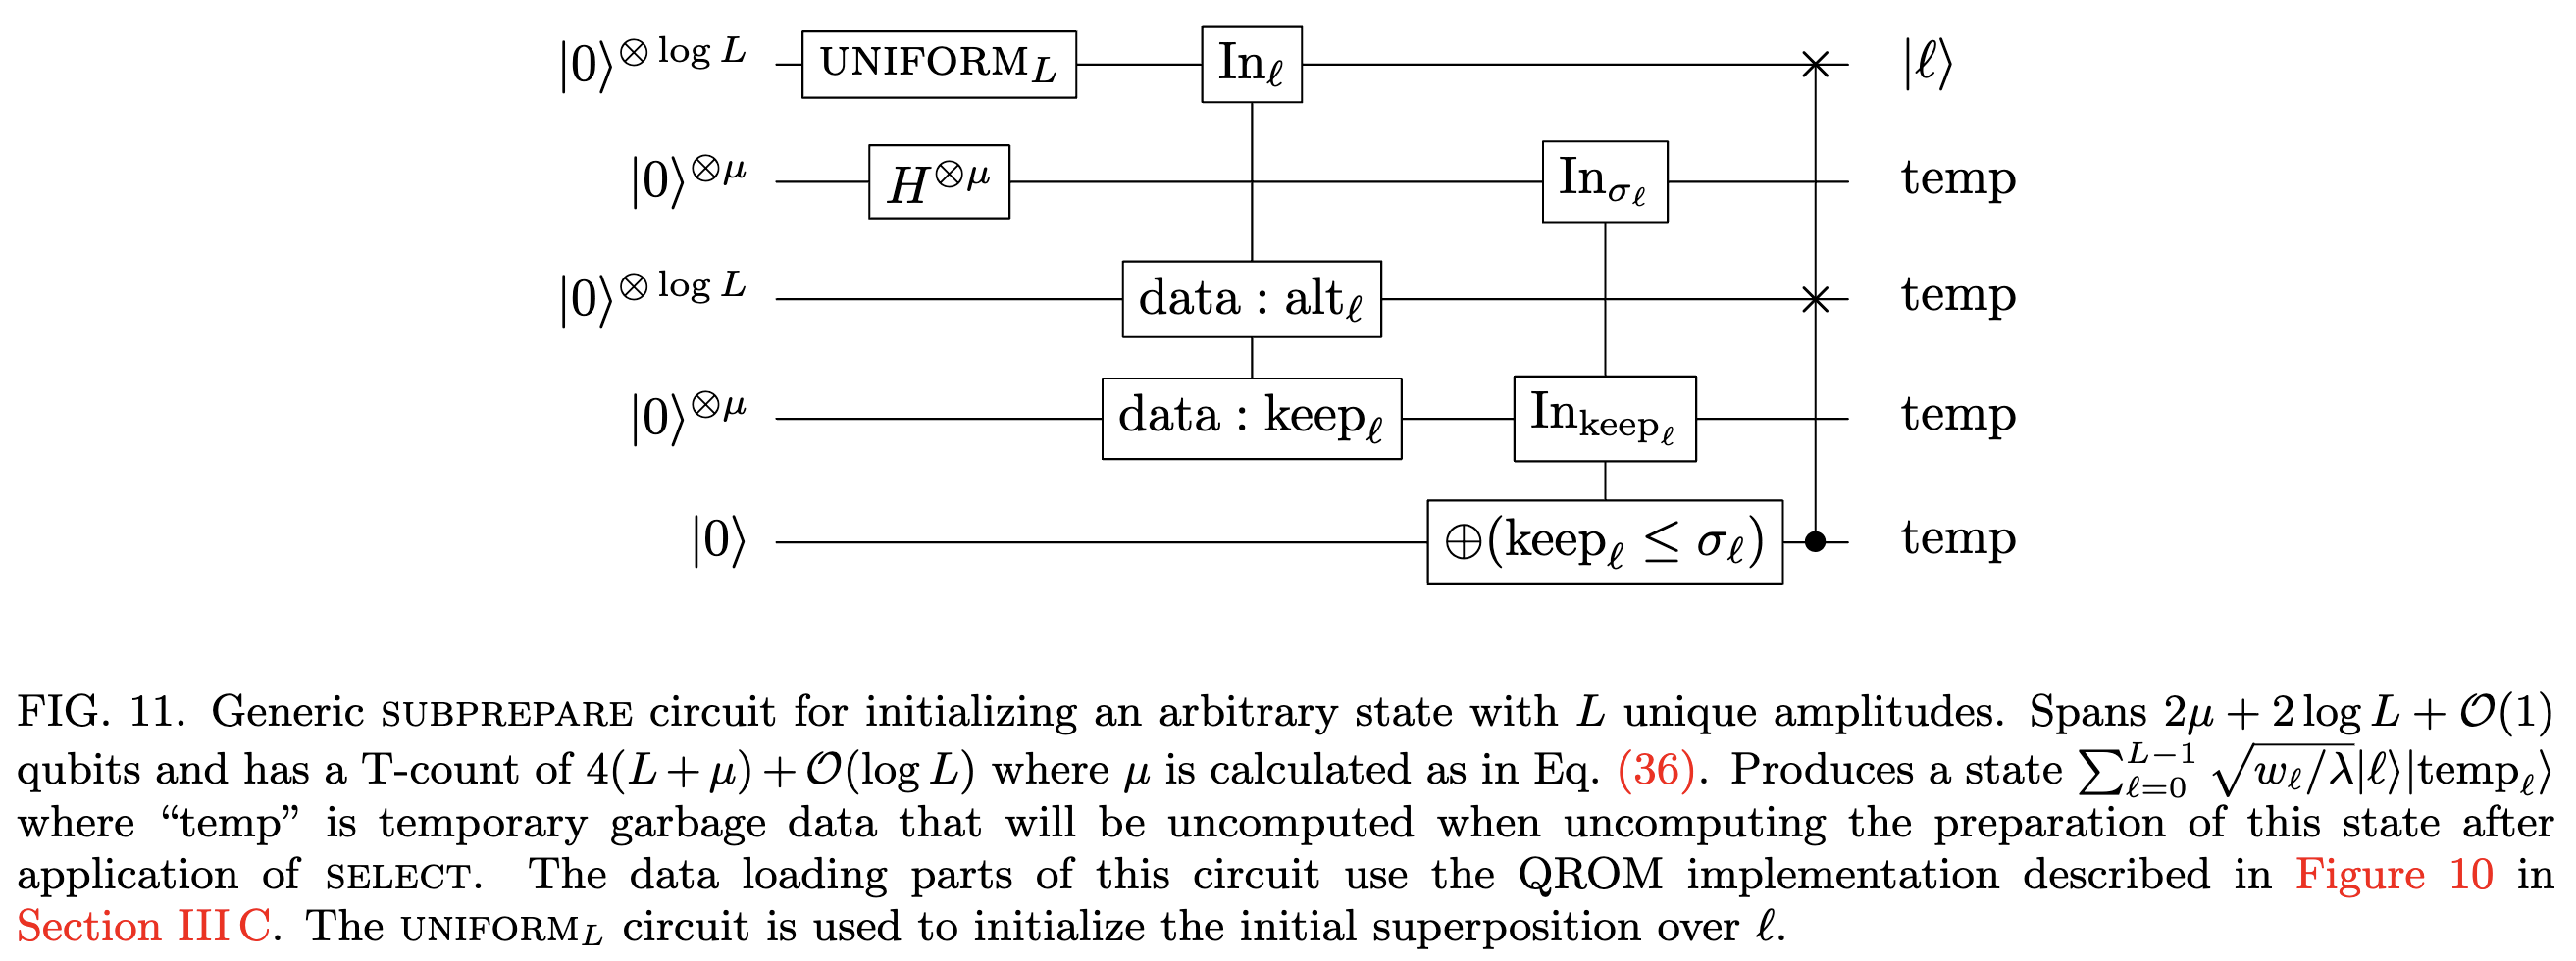

Qualtran has a `StatePreparationAliasSampling` bloq which uses `QROM` to load the `alt` and `keep` values.


### References:
6. [Encoding Electronic Spectra in Quantum Circuits with Linear T Complexity](https://arxiv.org/abs/1805.03662).
    Babbush et. al. (2018). Section III.D. and Figure 11.

### Step-1: Analyze costs of `StatePreparationAliasSampling` using `QROM`

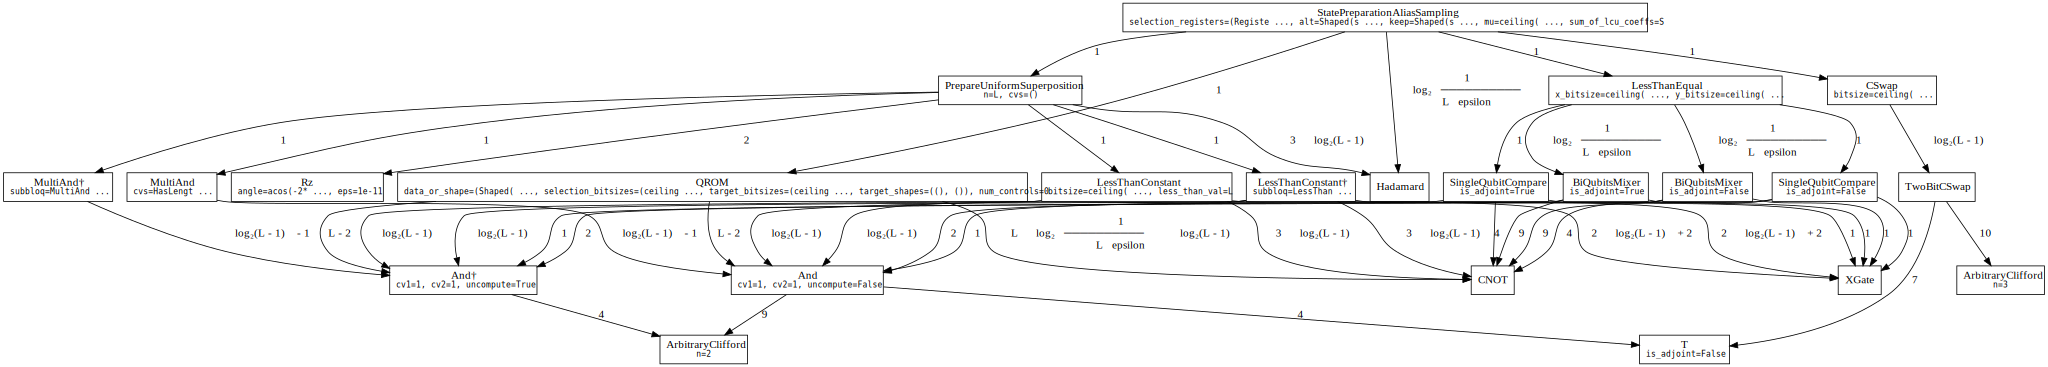

#### Counts totals:
 - `ArbitraryClifford(n=2)`: $\displaystyle 13 L + 26 \left\lceil{\operatorname{log}_{2}{\left(\frac{1}{L \epsilon} \right)}}\right\rceil + 39 \left\lceil{\operatorname{log}_{2}{\left(L - 1 \right)}}\right\rceil - 26$
 - `ArbitraryClifford(n=3)`: $\displaystyle 10 \left\lceil{\operatorname{log}_{2}{\left(L - 1 \right)}}\right\rceil$
 - `CNOT`: $\displaystyle L \left\lceil{\operatorname{log}_{2}{\left(\frac{1}{L \epsilon} \right)}}\right\rceil \left\lceil{\operatorname{log}_{2}{\left(L - 1 \right)}}\right\rceil + 18 \left\lceil{\operatorname{log}_{2}{\left(\frac{1}{L \epsilon} \right)}}\right\rceil + 6 \left\lceil{\operatorname{log}_{2}{\left(L - 1 \right)}}\right\rceil + 8$
 - `H`: $\displaystyle \left\lceil{\operatorname{log}_{2}{\left(\frac{1}{L \epsilon} \right)}}\right\rceil + 3 \left\lceil{\operatorname{log}_{2}{\left(L - 1 \right)}}\right\rceil$
 - `Rz(acos(-2**floor(log2(L))/L + 1)/piπ)`: 2
 - `T`: $\displaystyle 4 L + 8 \left\lceil{\operatorname{log}_{2}{\left(\frac{1}{L \epsilon} \right)}}\right\rceil + 19 \left\lceil{\operatorname{log}_{2}{\left(L - 1 \right)}}\right\rceil - 8$
 - `XGate`: $\displaystyle 2 \left\lceil{\operatorname{log}_{2}{\left(\frac{1}{L \epsilon} \right)}}\right\rceil + 4 \left\lceil{\operatorname{log}_{2}{\left(L - 1 \right)}}\right\rceil + 6$

### T-Counts for `StatePreparationAliasSampling` using QROM to load a state with $L$ coefficients with accuracy $\epsilon$.

<IPython.core.display.Math object>

In [ ]:
from qualtran.bloqs.state_preparation import StatePreparationAliasSampling

n_coeffs, sum_coeff, eps = sympy.symbols(r"L S \epsilon")
# Exercise: Construct a `state_prep_alias_symb` bloq using `StatePreparationAliasSampling.from_n_coeff`.
state_prep_alias_symb = StatePreparationAliasSampling.from_n_coeff(
    n_coeffs, sum_coeff, probability_epsilon=eps
)
# Exercise: Plot the call graph and show counts sigma for `state_prep_alias_symb`
g, sigma = state_prep_alias_symb.call_graph()
show_call_graph(g)
show_counts_sigma(sigma)
show_t_counts(state_prep_alias_symb, "### T-Counts for `StatePreparationAliasSampling` using QROM to load a state with $L$ coefficients with accuracy $\epsilon$.")

### Step-2: Analyze costs of `StatePreparationAliasSampling` using `SelectSwapQROM`

We will implement a new bloq `StatePreparationAliasSamplingViaSSQROM` that uses the `SelectSwapQROM` instead of `QROM` and analyze its costs

In [ ]:
import attrs

@attrs.frozen
class StatePreparationAliasSamplingViaSSQROM(StatePreparationAliasSampling):
    @classmethod
    def from_n_coeff(cls, n_coeff, sum_of_lcu_coeffs, *, probability_epsilon,) -> 'StatePreparationAliasSamplingViaSSQROM':
        """Factory to construct the state preparation gate for symbolic number of LCU coefficients."""
        state_prep = StatePreparationAliasSampling.from_n_coeff(n_coeff, sum_of_lcu_coeffs, probability_epsilon=probability_epsilon)
        return StatePreparationAliasSamplingViaSSQROM(
            selection_registers=state_prep.selection_registers,
            alt=state_prep.alt,
            keep=state_prep.keep,
            mu=state_prep.mu,
            sum_of_lcu_coeffs=state_prep.sum_of_lcu_coeffs,
        )

    @cached_property
    def qrom_bloq(self) -> SelectSwapQROM:
        # Exercise: Return a `SelectSwapQROM` bloq constructed using
        # - data_or_shape: (self.alt, self.keep)
        # - selection_bitsizes: (self.selection_bitsize,)
        # - target_bitsizes: (self.alternates_bitsize, self.keep_bitsize)
        return SelectSwapQROM(
            (self.alt, self.keep),
            (self.selection_bitsize,),
            (self.alternates_bitsize, self.keep_bitsize),
            use_dirty_ancilla=False
        )


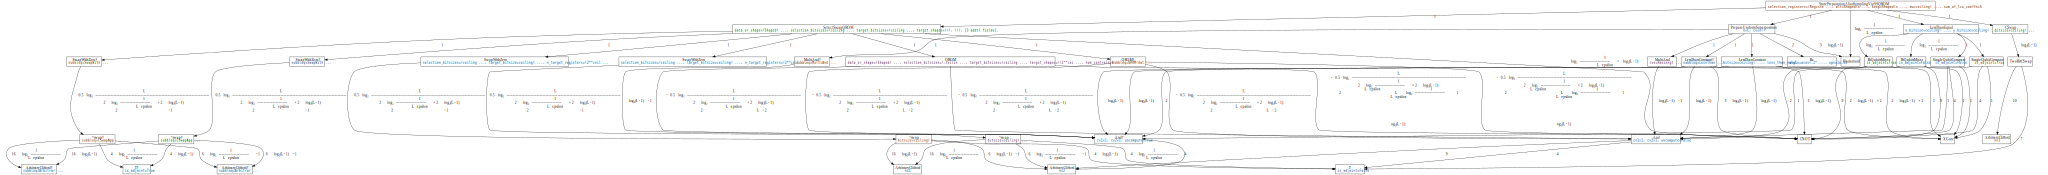

#### Counts totals:
 - `Adjoint(subbloq=ArbitraryClifford(n=1))`: $\displaystyle 16 \cdot \left(2^{\left\lceil{0.5 \operatorname{log}_{2}{\left(\frac{L}{2 \left\lceil{\operatorname{log}_{2}{\left(\frac{1}{L \epsilon} \right)}}\right\rceil + 2 \left\lceil{\operatorname{log}_{2}{\left(L - 1 \right)}}\right\rceil} \right)}}\right\rceil} - 1\right) \left\lceil{\operatorname{log}_{2}{\left(\frac{1}{L \epsilon} \right)}}\right\rceil + 16 \cdot \left(2^{\left\lceil{0.5 \operatorname{log}_{2}{\left(\frac{L}{2 \left\lceil{\operatorname{log}_{2}{\left(\frac{1}{L \epsilon} \right)}}\right\rceil + 2 \left\lceil{\operatorname{log}_{2}{\left(L - 1 \right)}}\right\rceil} \right)}}\right\rceil} - 1\right) \left\lceil{\operatorname{log}_{2}{\left(L - 1 \right)}}\right\rceil$
 - `Adjoint(subbloq=ArbitraryClifford(n=2))`: $\displaystyle \left(2^{\left\lceil{0.5 \operatorname{log}_{2}{\left(\frac{L}{2 \left\lceil{\operatorname{log}_{2}{\left(\frac{1}{L \epsilon} \right)}}\right\rceil + 2 \left\lceil{\operatorname{log}_{2}{\left(L - 1 \right)}}\right\rceil} \right)}}\right\rceil} - 1\right) \left(6 \left\lceil{\operatorname{log}_{2}{\left(\frac{1}{L \epsilon} \right)}}\right\rceil - 1\right) + \left(2^{\left\lceil{0.5 \operatorname{log}_{2}{\left(\frac{L}{2 \left\lceil{\operatorname{log}_{2}{\left(\frac{1}{L \epsilon} \right)}}\right\rceil + 2 \left\lceil{\operatorname{log}_{2}{\left(L - 1 \right)}}\right\rceil} \right)}}\right\rceil} - 1\right) \left(6 \left\lceil{\operatorname{log}_{2}{\left(L - 1 \right)}}\right\rceil - 1\right)$
 - `ArbitraryClifford(n=1)`: $\displaystyle 16 \cdot \left(2^{\left\lceil{0.5 \operatorname{log}_{2}{\left(\frac{L}{2 \left\lceil{\operatorname{log}_{2}{\left(\frac{1}{L \epsilon} \right)}}\right\rceil + 2 \left\lceil{\operatorname{log}_{2}{\left(L - 1 \right)}}\right\rceil} \right)}}\right\rceil} - 1\right) \left\lceil{\operatorname{log}_{2}{\left(\frac{1}{L \epsilon} \right)}}\right\rceil + 16 \cdot \left(2^{\left\lceil{0.5 \operatorname{log}_{2}{\left(\frac{L}{2 \left\lceil{\operatorname{log}_{2}{\left(\frac{1}{L \epsilon} \right)}}\right\rceil + 2 \left\lceil{\operatorname{log}_{2}{\left(L - 1 \right)}}\right\rceil} \right)}}\right\rceil} - 1\right) \left\lceil{\operatorname{log}_{2}{\left(L - 1 \right)}}\right\rceil$
 - `ArbitraryClifford(n=2)`: $\displaystyle \left(2^{\left\lceil{0.5 \operatorname{log}_{2}{\left(\frac{L}{2 \left\lceil{\operatorname{log}_{2}{\left(\frac{1}{L \epsilon} \right)}}\right\rceil + 2 \left\lceil{\operatorname{log}_{2}{\left(L - 1 \right)}}\right\rceil} \right)}}\right\rceil} - 1\right) \left(6 \left\lceil{\operatorname{log}_{2}{\left(\frac{1}{L \epsilon} \right)}}\right\rceil - 1\right) + \left(2^{\left\lceil{0.5 \operatorname{log}_{2}{\left(\frac{L}{2 \left\lceil{\operatorname{log}_{2}{\left(\frac{1}{L \epsilon} \right)}}\right\rceil + 2 \left\lceil{\operatorname{log}_{2}{\left(L - 1 \right)}}\right\rceil} \right)}}\right\rceil} - 1\right) \left(6 \left\lceil{\operatorname{log}_{2}{\left(L - 1 \right)}}\right\rceil - 1\right) + 26 \left\lceil{2^{- \left\lceil{0.5 \operatorname{log}_{2}{\left(\frac{L}{2 \left\lceil{\operatorname{log}_{2}{\left(\frac{1}{L \epsilon} \right)}}\right\rceil + 2 \left\lceil{\operatorname{log}_{2}{\left(L - 1 \right)}}\right\rceil} \right)}}\right\rceil} L}\right\rceil + 26 \left\lceil{\operatorname{log}_{2}{\left(\frac{1}{L \epsilon} \right)}}\right\rceil + 39 \left\lceil{\operatorname{log}_{2}{\left(L - 1 \right)}}\right\rceil - 52$
 - `ArbitraryClifford(n=3)`: $\displaystyle 10 \left\lceil{\operatorname{log}_{2}{\left(L - 1 \right)}}\right\rceil$
 - `CNOT`: $\displaystyle 2 \left\lceil{2^{- \left\lceil{0.5 \operatorname{log}_{2}{\left(\frac{L}{2 \left\lceil{\operatorname{log}_{2}{\left(\frac{1}{L \epsilon} \right)}}\right\rceil + 2 \left\lceil{\operatorname{log}_{2}{\left(L - 1 \right)}}\right\rceil} \right)}}\right\rceil} L}\right\rceil \left\lceil{\operatorname{log}_{2}{\left(\frac{1}{L \epsilon} \right)}}\right\rceil \left\lceil{\operatorname{log}_{2}{\left(L - 1 \right)}}\right\rceil + 19 \left\lceil{\operatorname{log}_{2}{\left(\frac{1}{L \epsilon} \right)}}\right\rceil + 7 \left\lceil{\operatorname{log}_{2}{\left(L - 1 \right)}}\right\rceil + 8$
 - `H`: $\displaystyle \left\lceil{\operatorname{log}_{2}{\left(\frac{1}{L \epsilon} \right)}}\right\rceil + 3 \left\lceil{\operatorname{log}_{2}{\left(L - 1 \right)}}\right\rceil$
 - `Rz(acos(-2**floor(log2(L))/L + 1)/piπ)`: 2
 - `T`: $\displaystyle 4 \cdot \left(2^{\left\lceil{0.5 \operatorname{log}_{2}{\left(\frac{L}{2 \left\lceil{\operatorname{log}_{2}{\left(\frac{1}{L \epsilon} \right)}}\right\rceil + 2 \left\lceil{\operatorname{log}_{2}{\left(L - 1 \right)}}\right\rceil} \right)}}\right\rceil} - 1\right) \left\lceil{\operatorname{log}_{2}{\left(\frac{1}{L \epsilon} \right)}}\right\rceil + 4 \cdot \left(2^{\left\lceil{0.5 \operatorname{log}_{2}{\left(\frac{L}{2 \left\lceil{\operatorname{log}_{2}{\left(\frac{1}{L \epsilon} \right)}}\right\rceil + 2 \left\lceil{\operatorname{log}_{2}{\left(L - 1 \right)}}\right\rceil} \right)}}\right\rceil} - 1\right) \left\lceil{\operatorname{log}_{2}{\left(L - 1 \right)}}\right\rceil + 8 \left\lceil{2^{- \left\lceil{0.5 \operatorname{log}_{2}{\left(\frac{L}{2 \left\lceil{\operatorname{log}_{2}{\left(\frac{1}{L \epsilon} \right)}}\right\rceil + 2 \left\lceil{\operatorname{log}_{2}{\left(L - 1 \right)}}\right\rceil} \right)}}\right\rceil} L}\right\rceil + 8 \left\lceil{\operatorname{log}_{2}{\left(\frac{1}{L \epsilon} \right)}}\right\rceil + 19 \left\lceil{\operatorname{log}_{2}{\left(L - 1 \right)}}\right\rceil - 16$
 - `T†`: $\displaystyle 4 \cdot \left(2^{\left\lceil{0.5 \operatorname{log}_{2}{\left(\frac{L}{2 \left\lceil{\operatorname{log}_{2}{\left(\frac{1}{L \epsilon} \right)}}\right\rceil + 2 \left\lceil{\operatorname{log}_{2}{\left(L - 1 \right)}}\right\rceil} \right)}}\right\rceil} - 1\right) \left\lceil{\operatorname{log}_{2}{\left(\frac{1}{L \epsilon} \right)}}\right\rceil + 4 \cdot \left(2^{\left\lceil{0.5 \operatorname{log}_{2}{\left(\frac{L}{2 \left\lceil{\operatorname{log}_{2}{\left(\frac{1}{L \epsilon} \right)}}\right\rceil + 2 \left\lceil{\operatorname{log}_{2}{\left(L - 1 \right)}}\right\rceil} \right)}}\right\rceil} - 1\right) \left\lceil{\operatorname{log}_{2}{\left(L - 1 \right)}}\right\rceil$
 - `XGate`: $\displaystyle 2 \left\lceil{\operatorname{log}_{2}{\left(\frac{1}{L \epsilon} \right)}}\right\rceil + 4 \left\lceil{\operatorname{log}_{2}{\left(L - 1 \right)}}\right\rceil + 6$

In [ ]:
from qualtran.bloqs.state_preparation import StatePreparationAliasSampling

n_coeffs, sum_coeff, eps = sympy.symbols(r"L S \epsilon")
# Exercise: Construct a `state_prep_alias_symb_via_ssqrom` bloq using `StatePreparationAliasSamplingViaSSQROM.from_n_coeff`.
state_prep_alias_symb_via_ssqrom = StatePreparationAliasSamplingViaSSQROM.from_n_coeff(
    n_coeffs, sum_coeff, probability_epsilon=eps
)
# Exercise: Plot the call graph and show counts sigma for `state_prep_alias_symb_via_ssqrom`
g, sigma = state_prep_alias_symb_via_ssqrom.call_graph()
show_call_graph(g)
show_counts_sigma(sigma)

In [ ]:
show_t_counts(state_prep_alias_symb_via_ssqrom, "### T-Counts for `StatePreparationAliasSampling` using SelectSwapQROM to load a state with $L$ coefficients with accuracy $\epsilon$.")

### T-Counts for `StatePreparationAliasSampling` using SelectSwapQROM to load a state with $L$ coefficients with accuracy $\epsilon$.

<IPython.core.display.Math object>

### Step-2: Compare costs of `StatePreparationAliasSampling` using `QROM` and `SelectSwapQROM`


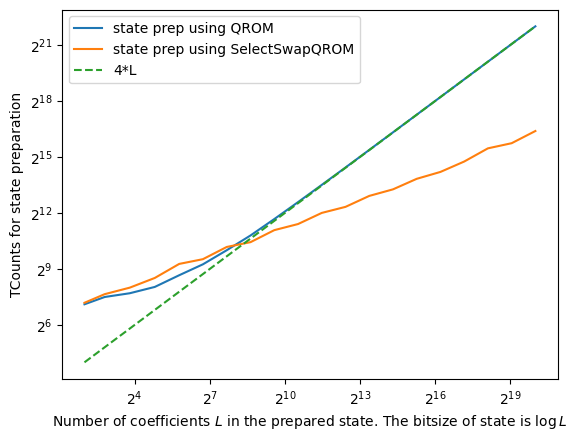

In [ ]:
from qualtran.resource_counting import get_cost_value, QubitCount

n_coeffs = np.logspace(2, 20, 20, base=2, dtype=int).tolist()
eps = 1e-5
state_prep_qrom_cost, state_prep_qroam_cost = [], []


state_prep_qrom_cost = [StatePreparationAliasSampling.from_n_coeff(n, sum_coeff, probability_epsilon=eps).t_complexity().t for n in n_coeffs]
state_prep_qroam_cost = [StatePreparationAliasSamplingViaSSQROM.from_n_coeff(n, sum_coeff, probability_epsilon=eps).t_complexity().t for n in n_coeffs]

plt.plot(n_coeffs, state_prep_qrom_cost, label='state prep using QROM')
plt.plot(n_coeffs, state_prep_qroam_cost, label='state prep using SelectSwapQROM')
plt.plot(n_coeffs, [4 * x for x in n_coeffs], label='4*L', linestyle='--')
plt.ylabel('TCounts for state preparation')
plt.xlabel('Number of coefficients $L$ in the prepared state. The bitsize of state is $\log{L}$')
plt.xscale('log', base=2)
plt.yscale('log', base=2)
plt.legend()